In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [2]:
import sys
import os
import time
import datetime
import argparse
import torch
import shutil
import torchvision
from tqdm.notebook import tqdm
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import kornia
sys.path.append('../')

from pycode.dataset import RLBench_dataset_VP, imageaug_full_transform, train_val_split
from pycode.config import _C as cfg
from pycode.model.VideoPrediction import VIDEO_HOURGLASS, Discriminator
from pycode.loss.vp_loss import Test_Loss_Video
from pycode.misc import build_dataset_VP, str2bool, save_args, save_checkpoint, load_checkpoint
from pycode.misc import make_overlay_image, make_overlay_image_and_heatmap, make_pos_image, convert_heatmap


kornia requires version >= 3.6. your version 3.6


In [3]:
# parser
parser = argparse.ArgumentParser(description='parser for image generator')
parser.add_argument('--config_file', type=str, default='', metavar='FILE', help='if not specified, use chepoint_path')
parser.add_argument('--output_dirname', type=str, default='', help='if not specified, use checkpoint_path')
parser.add_argument('--checkpoint_path','-c', type=str, help='e.g. output/RLdata/VP_pcf_dis_random/model_log/checkpoint_epoch0_iter100000/')
args = parser.parse_args(args=['--config_file','../configs/RLBench_test_VP.yaml', '--output_dirname','vp_result_with_depth_test'])

# get cfg data
if len(args.config_file) > 0:
    print('Loaded configration file {}'.format(args.config_file))
    cfg.merge_from_file(args.config_file)
else:
    config_dir = os.path.abspath(os.path.join(args.checkpoint_path, '../../'))
    file_list = os.listdir(config_dir)
    print(file_list)
    yaml_file_name = [x for x in file_list if '.yaml' in x]
    print(yaml_file_name)
    config_file_path = os.path.join(config_dir, yaml_file_name[0])
    print('Loaded configration file {}'.format(config_file_path))
    cfg.merge_from_file(config_file_path)

# define output dirname
if len(args.output_dirname) > 0:
    output_dirname = args.output_dirname
    output_dirname = os.path.join(cfg.BASIC.OUTPUT_DIR, cfg.DATASET.NAME, cfg.DATASET.RLBENCH.TASK_LIST[0], output_dirname)
else:
    output_dirname = os.path.abspath(os.path.join(args.checkpoint_path,"../../"))

cfg.PRED_LEN = 8
cfg.BASIC.NUM_GPU = 1
cfg.BASIC.BATCH_SIZE = 1

# make output dir
os.makedirs(cfg.BASIC.OUTPUT_DIR, exist_ok=True)

# difine save model path
model_path = os.path.join(cfg.BASIC.OUTPUT_DIR, 'model_log')

# set seed and cuda
torch.manual_seed(cfg.BASIC.SEED)
cuda = torch.cuda.is_available()
device = torch.device(cfg.BASIC.DEVICE)

if cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(cfg.BASIC.SEED)

Loaded configration file ../configs/RLBench_test_VP.yaml


In [4]:
output_dirname

'../output/RLBench3/PickUpCup/vp_result_with_depth_test'

In [5]:
from pycode.misc import build_dataset_MP

# set dataset
test_dataset = build_dataset_MP(cfg, mode='train')

# set dataloader
test_dataloader = DataLoader(test_dataset, batch_size=cfg.BASIC.BATCH_SIZE, shuffle=False, num_workers=cfg.BASIC.WORKERS)

# set model 1
cfg.VIDEO_HOUR.MODE = 'pcf'
model1 = VIDEO_HOURGLASS(cfg)
video_checkpoint_path1 = '../output/RLBench3/PickUpCup/VP_pcf_PickUpCup_depth/model_log/checkpoint_iter100000/vp.pth'
model1, _, _, _, _ = load_checkpoint(model1, video_checkpoint_path1, fix_parallel=True)
model1 = torch.nn.DataParallel(model1, device_ids = list(range(cfg.BASIC.NUM_GPU)))
model1 = model1.to(device)

# set model 2
cfg.VIDEO_HOUR.MODE = 'pc'
model2 = VIDEO_HOURGLASS(cfg)
video_checkpoint_path2 = '../output/RLBench3/PickUpCup/VP_pc_PickUpCup_depth/model_log/checkpoint_iter100000/vp.pth'
model2, _, _, _, _ = load_checkpoint(model2, video_checkpoint_path2, fix_parallel=True)
model2 = torch.nn.DataParallel(model2, device_ids = list(range(cfg.BASIC.NUM_GPU)))
model2 = model2.to(device)

start_epoch, start_iter = 0, 1

def make_videomodel_input(inputs, device, sequence_id=0, mode='pcf'):
    '''
    output:
    dictionary{
    rgb => torch.Tensor shape=(B,S,C,H,W),
    pose => torch.Tensor shape=(B,S,C,H,W)}
    '''
    if mode == 'pcf':
        index_list = [sequence_id, sequence_id+1, sequence_id+3]
        rgb = inputs['rgb'][:,index_list].to(device)
        pose_heatmap = inputs['heatmap'][:,:4].to(device)
        pose_xyz = inputs['pose_xyz'][:,:4].to(device)
        rotation_matrix = inputs['rotation_matrix'][:,:4].to(device)
        grasp = inputs['grasp'][:,:4].to(device)
        if cfg.VIDEO_HOUR.INPUT_DEPTH:
            depth = inputs['depth'][:,index_list].to(device)
    elif mode == 'pc':
        index_list = [sequence_id, sequence_id+1]
        rgb = inputs['rgb'][:,index_list].to(device)
        pose_heatmap = inputs['heatmap'][:,:3].to(device)
        pose_xyz = inputs['pose_xyz'][:,:3].to(device)
        rotation_matrix = inputs['rotation_matrix'][:,:3].to(device)
        grasp = inputs['grasp'][:,:3].to(device)
        if cfg.VIDEO_HOUR.INPUT_DEPTH:
            depth = inputs['depth'][:,index_list].to(device)
    elif mode == 'c':
        rgb = inputs['rgb'][:,1].to(device)
        pose_heatmap = inputs['heatmap'][:,1:3].to(device)
        pose_xyz = inputs['pose_xyz'][:,1:3].to(device)
        rotation_matrix = inputs['rotation_matrix'][:,1:3].to(device)
        grasp = inputs['grasp'][:,1:3].to(device)
        if cfg.VIDEO_HOUR.INPUT_DEPTH:
            depth = inputs['depth'][:,1].to(device)
    
    input_dict = {}
    input_dict['rgb'] = rgb
    input_dict['heatmap'] = pose_heatmap
    input_dict['pose_xyz'] = pose_xyz
    input_dict['rotation_matrix'] = rotation_matrix
    input_dict['grasp'] = grasp
    if cfg.VIDEO_HOUR.INPUT_DEPTH:
        input_dict['depth'] = depth

    return input_dict
    
def save_diff_heatmap_overlay(pred, gt):
    import numpy as np
    import cv2
    totensor = torchvision.transforms.ToTensor()
    heatmap = torch.abs(pred - gt).squeeze(1)

    for i in range(heatmap.shape[0]):
        image_ins = pred[i].cpu().numpy().transpose((1, 2, 0))*255
        image_ins = image_ins.clip(0, 255).astype(np.uint8)
        
        heatmap_ins = torch.mean(heatmap[i],dim=0).cpu().numpy()*255
        heatmap_ins = heatmap_ins.clip(0, 255)
        heatmap_ins  = 255 - heatmap_ins.astype(np.uint8)

        heatmap_ins = cv2.applyColorMap(heatmap_ins, cv2.COLORMAP_JET)
        overlayed_image = cv2.addWeighted(heatmap_ins, 0.6, image_ins, 0.4, 0)
        overlayed_image = totensor(overlayed_image.transpose((0,1,2)))

        if i == 0:
            overlayed_image_batch = torch.unsqueeze(overlayed_image,0)
        else:
            overlayed_image_batch = torch.cat((overlayed_image_batch, torch.unsqueeze(overlayed_image,0)), 0)
    return overlayed_image_batch

calc_psnr = kornia.losses.psnr_loss


length of future is 8 frame
load json data
fix parallel
fix parallel


In [6]:
checkpoint_dir = os.path.join(output_dirname,'image')
os.makedirs(checkpoint_dir, exist_ok=True)

iteration = 0
for inputs in tqdm(test_dataloader):
    with torch.no_grad():
        gt_image = inputs['rgb'][:,2].to(device)
        outputs1 = model1(make_videomodel_input(inputs,device,mode='pcf'))
        output_image1 = outputs1['rgb']
        PSNR1 = calc_psnr(torch.clamp(output_image1*255,0,255),gt_image*255, 255)
        
        outputs2 = model2(make_videomodel_input(inputs,device,mode='pc'))
        output_image2 = outputs2['rgb']
        PSNR2 = calc_psnr(torch.clamp(output_image2*255,0,255),gt_image*255, 255)
        if PSNR1 - PSNR2 > 0.5:
            diff_image_gt = save_diff_heatmap_overlay(gt_image,gt_image)
            diff_image1 = save_diff_heatmap_overlay(output_image1,gt_image)
            diff_image2 = save_diff_heatmap_overlay(output_image2, gt_image)
            save_image = torch.cat((gt_image.cpu(),output_image1.cpu(),output_image2.cpu(),diff_image_gt, diff_image1, diff_image2),0)
            diff_psnr = PSNR1 - PSNR2
            # save output image
            save_image_path = os.path.join(checkpoint_dir,'train_image_output_{}_{}.jpg'.format(iteration,diff_psnr.cpu().item()))
            torchvision.utils.save_image(save_image, save_image_path,nrow=3)
    
    iteration += 1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/misc/dl00/tendon/project/Imitation_Learning/MotionPrediction/env/dl11/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-f4b7370719e9>", line 12, in <module>
    outputs2 = model2(make_videomodel_input(inputs,device,mode='pc'))
  File "<ipython-input-5-8dd613ced6de>", line 45, in make_videomodel_input
    rgb = inputs['rgb'][:,index_list].to(device)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/misc/dl00/tendon/project/Imitation_Learning/MotionPrediction/env/dl11/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback

TypeError: object of type 'NoneType' has no len()

In [8]:
topil = torchvision.transforms.ToPILImage()

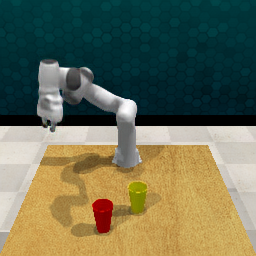

In [11]:
topil(output_image1[0])

In [10]:
output_image1.shape

torch.Size([1, 3, 256, 256])

In [12]:
model1

DataParallel(
  (module): VIDEO_HOURGLASS(
    (img_encoder): Encoder(
      (res_blocks): ModuleList(
        (0): ResSubsampleBlock(
          (shortcut): Sequential(
            (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
            (1): ConvBlock(
              (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
              (act): ReLU()
            )
          )
          (conv1): ConvBlock(
            (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): ReLU()
          )
          (conv2): Sequential(
            (0): ConvBlock(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): ReLU()
            )
            (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
          )
        )
        (1): ResSubsampleBlock(
          (shortcut): Sequential(
            (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
            (1): ConvBlock(
              (conv): Con